<a href="https://colab.research.google.com/github/mylethidiem/data-science-artificial-intelligence-projects/blob/applied_prj_for_softmax_regression/Twitter-Sentiment-Analysis/notebooks/Pytorch_Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# Phần code này không chạy nổi trên máy cá nhân mình mình chạy trên Colab

In [1]:
# https://drive.google.com/file/d/1aQ8OlUljwEm7RLZz8Qf4xzim0nDewHfU/view?usp=sharing
!gdown -q --id 1aQ8OlUljwEm7RLZz8Qf4xzim0nDewHfU

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [2]:
!unzip twitter_sentiment_analysis_3cls_dataset.zip

Archive:  twitter_sentiment_analysis_3cls_dataset.zip
  inflating: Twitter_Data.csv        


In [5]:
#Phần code chạy trên Colab
dataset_path = 'Twitter_Data.csv'

In [ ]:
# Phần code không cần chạy trên Colab
!mv Twitter_Data.csv ../data/
dataset_path = '../data/Twitter_Data.csv'

In [ ]:
!pip -q install torch nltk

## **1. Import libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # Xử lý Biểu thức chính quy (Regular Expressions) cho tiền xử lý văn bản
import torch  # Thư viện PyTorch cơ sở
import torch.nn as nn  # Các module xây dựng mạng nơ-ron (như các lớp Linear, Conv)
import torch.optim as optim  # Các thuật toán tối ưu hóa (Optimizers) như Adam, SGD
import nltk  # Natural Language Toolkit (Bộ công cụ Xử lý Ngôn ngữ Tự nhiên)

nltk.download('stopwords')  # Tải xuống danh sách từ dừng (stopwords)

from sklearn.model_selection import train_test_split  # Chia dữ liệu thành tập huấn luyện và kiểm thử
from sklearn.feature_extraction.text import TfidfVectorizer  # Chuyển đổi văn bản thành vector TF-IDF
from nltk.corpus import stopwords  # Nhập danh sách từ dừng
from nltk.stem import SnowballStemmer  # Công cụ Stemming (đưa từ về dạng gốc)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [54]:
random_state = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
torch.manual_seed(random_state)

Using device: cuda


## **2. Read dataset**

In [55]:
df = pd.read_csv(
    dataset_path
)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [57]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **3. Drop missing value**

In [58]:
null_rows = df.isnull().any(axis=1)
df[null_rows]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [59]:
df = df.dropna()

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## **4. Preprocessing data**



### Regular Regression
>> Mẫu `r'[^\w\s]'`

Phần quan trọng nhất là biểu thức chính quy:

* **`[...]`**: Khớp với bất kỳ ký tự nào nằm trong dấu ngoặc vuông.
* **`^` (Dấu mũ)**: Đặt ngay sau dấu ngoặc vuông, nó có nghĩa là **phủ định**. Nó khớp với **bất kỳ ký tự nào KHÔNG** nằm trong tập hợp theo sau nó.
* **`\w`**: Khớp với **bất kỳ ký tự chữ (a-z, A-Z), số (0-9) hoặc dấu gạch dưới (_)**. (`\w` viết tắt cho *word character*).
* **`\s`**: Khớp với **bất kỳ ký tự khoảng trắng (space, tab, newline)**. (`\s` viết tắt cho *whitespace*).

Tóm lại, **`[^\w\s]`** có nghĩa là **"tìm kiếm bất kỳ ký tự nào KHÔNG phải là chữ cái, số, dấu gạch dưới, hoặc khoảng trắng."** (tức là tất cả các dấu câu và ký tự đặc biệt).


>> Ví dụ Minh họa:

| Đầu vào (text) | Ký tự bị khớp (`[^\w\s]`) | Đầu ra |
| :--- | :--- | :--- |
| `"Hello! This is 100$. "` | `!`, `$`, `.` | `"Hello This is 100 "` |
| `"data-analysis@2025"` | `-`, `@` | `"dataanalysis2025"` |

Mẫu `r'https?:\/\/.*[\r\n]*'` được xây dựng để khớp với hầu hết các định dạng liên kết:

| Ký hiệu Regex | Ý nghĩa | Giải thích |
| :--- | :--- | :--- |
| **`http`** | Khớp chính xác với chuỗi ký tự "http". | Bắt đầu của URL. |
| **`s?`** | Khớp với ký tự "s" **một lần hoặc không lần nào**. | Điều này giúp khớp với cả `http` và `https`. |
| **`:\/`** | Khớp chính xác với chuỗi `:/`. | Kết hợp để khớp với `:` và hai dấu gạch chéo `//` (dấu `/` cần được thoát `\` vì nó có ý nghĩa đặc biệt trong một số ngữ cảnh regex). |
| **`.*`** | Khớp với **bất kỳ ký tự nào** (`.`) lặp lại **không hoặc nhiều lần** (`*`). | Khớp với phần còn lại của liên kết (ví dụ: `google.com/path?query=123`). Đây là phần mở rộng nhất. |
| **`[\r\n]*`** | Khớp với **ký tự xuống dòng** (`\r` hoặc `\n`) lặp lại **không hoặc nhiều lần**. | Đảm bảo rằng nếu liên kết nằm ở cuối dòng, ký tự xuống dòng đi kèm cũng được xóa sạch, ngăn không cho khoảng trắng thừa xuất hiện. |


In [61]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Regular Expressions
    # Loại bỏ chữ viết tắt cũ của Retweet "RT" ở đầu dòng (thường gặp trên Twitter)
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlinks removal 'http://' hoặc 'https://'
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal (chỉ giữ lại từ, số, và khoảng trắng)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Rút gọn từ về dạng gốc (Stemming)
    stemmer = SnowballStemmer('english')
    words = text.split()
    # Áp dụng stemming cho từng từ
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

In [62]:
text = """We love this! Would you go?
#talk #makememories #unplug
#relax #iphone #smartphone #wifi #connect...
http://fb.me/6N3LsUpCu
"""
text = text_normalize(text)
text

'love would go talk makememori unplug relax iphon smartphon wifi connect'

In [63]:
# Áp dụng hàm 'text_normalize' lên từng phần tử (từng chuỗi văn bản) trong cột 'clean_text'.
# Mục đích là làm sạch, chuẩn hóa, và tiền xử lý toàn bộ dữ liệu văn bản.
df['clean_text'] = df['clean_text'].apply(
    lambda x: text_normalize(x)
)

/tmp/ipython-input-887339454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(


In [67]:
df

,clean_text,category
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0
...,...,...
162975,456 crore paid neerav modi recov congress lead...,-1.0
162976,dear rss terrorist payal gawar modi kill 1000 ...,-1.0
162977,cover interact forum left,0.0
162978,big project came india modi dream project happ...,0.0


In [68]:
vectorizer = TfidfVectorizer(
    # Max features (từ vựng) tối đa được sử dụng là 2000
    # TfidfVectorizer sẽ chọn 2000 từ có trọng số TF-IDF cao nhất
    max_features=2000
)
# 1. Học từ vựng và tính toán trọng số TF-IDF:
# fit_transform() thực hiện cả hai bước:
# a) Học từ điển (từ vựng) từ cột 'clean_text'
# b) Chuyển đổi văn bản thành ma trận TF-IDF (thường là ma trận thưa - sparse matrix)
# 2. Chuyển ma trận thưa sang ma trận dày (dense array) để dễ dàng thao tác với PyTorch hoặc các thư viện khác
X = vectorizer.fit_transform(
    df['clean_text']
).toarray()

In [69]:
print(X.shape)

(162969, 2000)


## **5. One-hot encoding label**

In [70]:
n_classes = df['category'].nunique() # Số lượng lớp (class) nunique in 'category'
n_samples = df['category'].size # Số lượng sample - dòng dữ liệu

# 1. Mã hóa nhãn (Label Encoding):
# Chuyển nhãn từ dạng số bắt đầu từ 0 sang dạng số nguyên không dấu (uint8) bắt đầu từ 1.
y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
print("y = ", y)

# 2. Chuẩn bị ma trận One-Hot Encoding:
# Tạo một ma trận y_encoded rỗng có kích thước (n_samples, n_classes)
y_encoded = np.array(
    [np.zeros(n_classes) for _ in range(n_samples)]
)
print("y_encoded zeros = ", y_encoded)

# 3. Áp dụng One-Hot Encoding:
# np.arange(n_samples) tạo chỉ số hàng (0, 1, 2, ...)
# y tạo chỉ số cột (các chỉ số lớp đã được chuyển đổi)
# Đặt giá trị 1 vào vị trí (hàng i, cột y[i]) tương ứng với lớp của mẫu i
y_encoded[np.arange(n_samples), y] = 1
print("y_encoded = ", y_encoded)

y =  [0 1 2 ... 1 1 2]
y_encoded zeros =  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
y_encoded =  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


## **6. Create train, val, test set**

In [71]:
# Chuyển đổi ma trận features (X) từ NumPy array sang PyTorch Tensor.
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y_encoded, dtype=torch.float32)

**Chia tập dữ liệu:**

  * **Validation Set (X\_val, y\_val):** $20\%$ tổng dữ liệu.
  * **Test Set (X\_test, y\_test):** $12.5\%$ của $80\%$ còn lại $= 10\%$ tổng dữ liệu.
  * **Training Set (X\_train, y\_train):** $70\%$ tổng dữ liệu.

In [78]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 114078
Number of val samples: 32594
Number of test samples: 16297


## **7. Define Softmax Regression model**

In [79]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(
            input_dim,
            output_dim,
            bias=True
        )

    def forward(self, x):
        return self.linear(x)

In [80]:
def compute_accuracy(y_hat, y_true):
    # trả về giá trị lớn nhất trên mỗi hàng và chỉ số của nó
    _, y_hat = torch.max(y_hat, dim=1)
    _, y_true = torch.max(y_true, dim=1)

    correct = (y_hat == y_true).sum().item()

    accuracy = (correct / len(y_true))

    return accuracy

## **8. Training**

In [81]:
lr = 0.1
epochs = 500

model = SoftmaxRegression(
    input_dim=X_train.shape[1],
    output_dim=y_train.shape[1]
).to(device)

print("device: ", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

device:  cuda


In [83]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    y_hat = model(X_train)

    # Compute loss
    train_loss = criterion(y_hat, y_train)

    train_losses.append(train_loss.item())

    train_acc = compute_accuracy(y_hat, y_train)
    train_accs.append(train_acc)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    model.eval()
    # Forward pass for validation data
    with torch.no_grad():
        y_val_hat = model(X_val)

        # Compute validation loss
        val_loss = criterion(y_val_hat, y_val)
        val_losses.append(val_loss.item())

        val_acc = compute_accuracy(y_val_hat, y_val)
        val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.100	Validation loss: 1.097

EPOCH 2:	Training loss: 1.097	Validation loss: 1.095

EPOCH 3:	Training loss: 1.095	Validation loss: 1.093

EPOCH 4:	Training loss: 1.093	Validation loss: 1.090

EPOCH 5:	Training loss: 1.090	Validation loss: 1.088

EPOCH 6:	Training loss: 1.088	Validation loss: 1.086

EPOCH 7:	Training loss: 1.087	Validation loss: 1.084

EPOCH 8:	Training loss: 1.085	Validation loss: 1.083

EPOCH 9:	Training loss: 1.083	Validation loss: 1.081

EPOCH 10:	Training loss: 1.082	Validation loss: 1.080

EPOCH 11:	Training loss: 1.080	Validation loss: 1.078

EPOCH 12:	Training loss: 1.079	Validation loss: 1.077

EPOCH 13:	Training loss: 1.077	Validation loss: 1.076

EPOCH 14:	Training loss: 1.076	Validation loss: 1.074

EPOCH 15:	Training loss: 1.075	Validation loss: 1.073

EPOCH 16:	Training loss: 1.074	Validation loss: 1.072

EPOCH 17:	Training loss: 1.073	Validation loss: 1.071

EPOCH 18:	Training loss: 1.072	Validation loss: 1.070

EPOCH 19:	Training

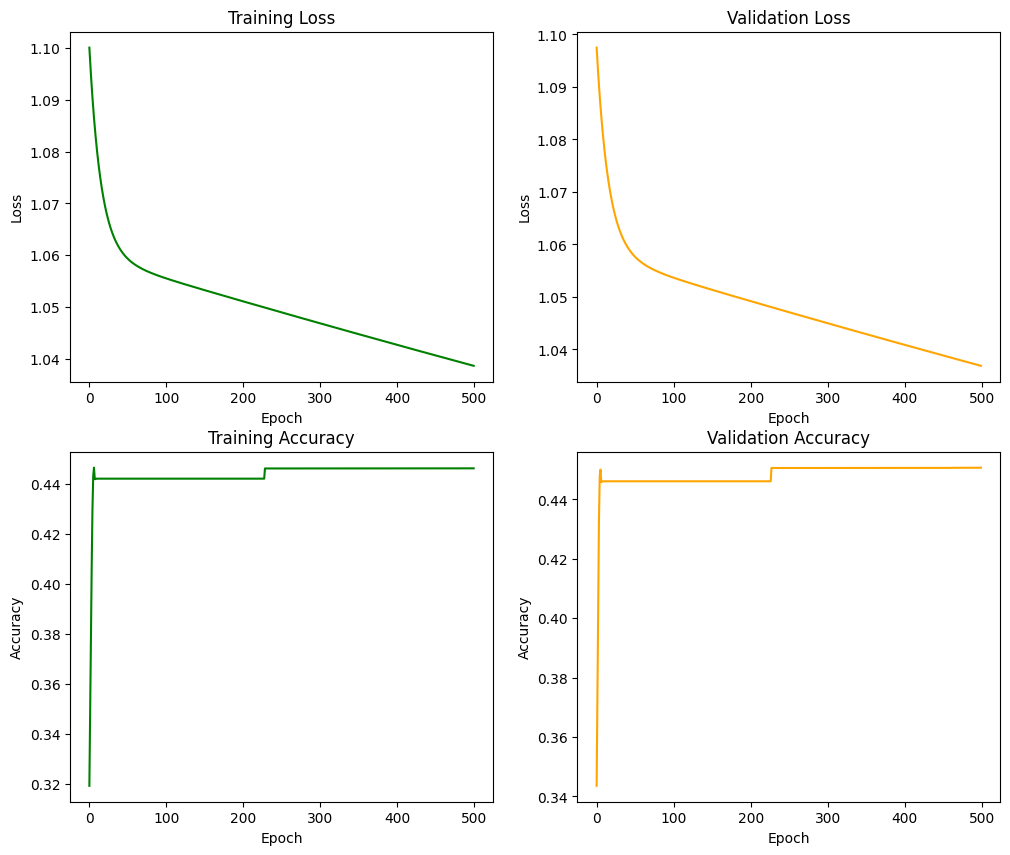

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **9. Evaluation**

In [85]:
# Val set
model.eval()
with torch.no_grad():
    y_hat = model(X_val)
    val_set_acc = compute_accuracy(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.4507271276922133


In [86]:
# Test set
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_acc = compute_accuracy(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.4491010615450696
